In [192]:
import numpy as np
import pandas as pd
ref_table_s = pd.read_csv('/Users/junsu/Documents/refPTomo.csv')
file = np.load('/Users/junsu/Documents/globocat_1.2.2_sample_P.npz', allow_pickle=True)

kmat_main = file['kmat'][:, :28358]
kmat_upper = file['kmat'][:, 28358:]
kmat = np.array(file['kmat'][:, :2578*11], dtype=np.float32)
upper_corr = file['kmat'][:, 2578*11:] @ ref_table_s['anomaly'].values[2578*11:]/100
res = np.array(file['res'][:2578*11] - upper_corr, dtype=np.float32)

KeyboardInterrupt: 

In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import load_npz
ref_table = pd.read_csv('/Users/junsu/Documents/refSTomo.csv')
kmat = load_npz('globocat_1.2.0_S_srqc_sparse.npz')
ttres = np.load('globocat_1.2.0_S_srqc_ttres.npz', allow_pickle=True)
# kmat[:, 2578*11:]
# kmat = np.array(file['kmat'][:, :2578*11])
upper_corr = kmat[:, 2578*11:] @ ref_table['anomaly'].values[2578*11:]/100
residuals = np.array(ttres['residual'] - upper_corr)

<Axes: >

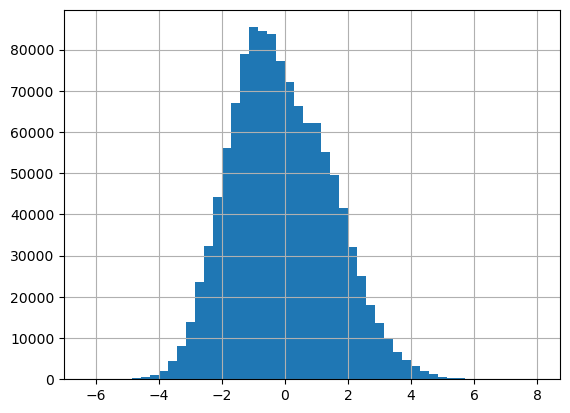

In [291]:
pd.Series(upper_corr).hist(bins=50)

In [3]:
import blockmodel
from scipy.sparse import csr_array, vstack
def get_csr_oneline(length, list1, list2):
    row = np.zeros(length, dtype=np.float32)
    for id in list1: row[id] = -1/len(list1)
    for id in list2: row[id] = 1/len(list2)
    return csr_array(row)

def get_smoothing_kernel(md, direction):
    nblk_per_layer = int(sum(md.number_of_blocks_in_band))
    loop = range(len(md)-(nblk_per_layer if direction == 'r' else 0))
    # print(loop)
    if direction == 'r':
        return vstack([get_csr_oneline(len(md),
                                       [i],
                                       [blk.id for blk in md.findNeighbor(md[i], direction='U')]) for i in loop])
    elif direction == 'h':
        return vstack([get_csr_oneline(len(md),
                                       [i],
                                       [blk.id for blk in md.findNeighbor(md[i], direction='E')]+
                                       [blk.id for blk in md.findNeighbor(md[i], direction='S')]+
                                       [blk.id for blk in md.findNeighbor(md[i], direction='W')]+
                                       [blk.id for blk in md.findNeighbor(md[i], direction='N')]) for i in loop])
    else:
        return vstack([get_csr_oneline(len(md),
                                       [blk.id for blk in md.findNeighbor(md[i], direction='S' if direction == 'lat' else 'W')],
                                       [blk.id for blk in md.findNeighbor(md[i], direction='N' if direction == 'lat' else 'E')]) for i in loop])

In [11]:
md = blockmodel.Model()
md[:] = md[:2578*11]
lambda_h = 4
lambda_v = 4

# k_smoothing = vstack([lambda_v*get_smoothing_kernel(md,'r'),
#                       lambda_h*get_smoothing_kernel(md,'lon'),
#                       lambda_h*get_smoothing_kernel(md,'lat')])
k_smoothing = vstack([lambda_v*get_smoothing_kernel(md,'r'),
                      lambda_h*get_smoothing_kernel(md,'h')])

In [12]:
k_smoothing.shape[0]

54138

In [5]:
from scipy.sparse import lil_matrix

def check_ill_values(row):
    return (np.sum(np.isnan(row.todense()),axis=1)+np.sum(np.isinf(row.todense()),axis=1))>0

def delete_row_lil(mat, i):
    if not isinstance(mat, lil_matrix):
        raise ValueError("works only for LIL format -- use .tolil() first")
    mat.rows = np.delete(mat.rows, i)
    mat.data = np.delete(mat.data, i)
    mat._shape = (mat._shape[0] - len(i), mat._shape[1])
    return mat

# smoothed_kmat = delete_row_lil(smoothed_kmat.tolil(), np.where(check_ill_values(smoothed_kmat))[0]).tocsr()

In [ ]:
from scipy.sparse.linalg import lsqr

# Solve kmat * m = res using LSQR
# (10000 * 2578*11)
# buggy in [500k, 550k]?
init = 500000
slc = slice(init,init+50000)
slc = slice(None,None)

sliced_kmat = kmat[slc, :2578*11]
ill_value_loc = np.where(check_ill_values(sliced_kmat))[0]
print(f"{len(ill_value_loc)} problematic rays removed:", ill_value_loc)
smoothed_kmat = vstack([delete_row_lil(sliced_kmat.tolil(), ill_value_loc).tocsr(), k_smoothing])
padded_residuals = np.pad(np.delete(residuals[slc], ill_value_loc), (0, k_smoothing.shape[0]))
# smoothed_kmat = vstack([kmat[slc, :2578*11], k_smoothing])
# padded_residuals = np.pad(residuals[slc], (0, k_smoothing.shape[0]))
m = lsqr(smoothed_kmat, padded_residuals, damp=4)[0]

21 problematic rays removed: [ 90954  93193 100756 102822 119072 127349 128455 129893 139556 140323
 148330 163315 163660 196061 324403 374928 471926 706789 792989 830618
 892261]


In [7]:
(min(m),max(m))

(np.float64(-0.814630549625009), np.float64(0.8331378583355722))

In [66]:
np.save('globotomo_p',m)

In [ ]:
from numpy import sin, cos, deg2rad
import blockmodel

def output_xyz(array, filepath, output_v=True, input_in_depth=False):
    # Extract longitude, latitude, and depth from res[0]
    lons = array[:, 0]
    lats = array[:, 1]
    z = array[:, 2]
    if output_v: vals = array[:, 3]

    # Assume Earth radius in km
    R_earth = 6371.0

    # Convert latitude and longitude to radians
    lats_rad = deg2rad(lats)
    lons_rad = deg2rad(lons)

    # Compute radius at each depth (depth is in km)
    if input_in_depth: r = R_earth - z
    else: r = z

    # Convert to cartesian coordinates
    x = r * cos(lats_rad) * cos(lons_rad)
    y = r * cos(lats_rad) * sin(lons_rad)
    z = r * sin(lats_rad)
    # print(z.max(),z.min())

    # Normalize x, y, z to [-0.5, 0.5]
    x_norm = x / 2 / R_earth
    y_norm = y / 2 / R_earth
    z_norm = z / 2 / R_earth

    if output_v:
        df = pd.DataFrame(np.stack([x_norm, y_norm, z_norm, vals], axis=1), columns=["x", "y", "z", "val"])
    else:
        df = pd.DataFrame(np.stack([x_norm, y_norm, z_norm], axis=1), columns=["x", "y", "z"])
    return df
    # df.to_csv(filepath, index=False)

md = blockmodel.Model()
data = np.array([ [blk.clon-360 if blk.clon>180 else blk.clon, 90-blk.clat, blk.crad] for blk in md])
data = np.insert(data, 3, 100*np.pad(m, (0, 2578*7)), axis=1)
# data
df = output_xyz(data, 'xxx')
df = df.rename(columns={'val': 'm1'})
df['m0'] = ref_table['anomaly']

In [10]:
df.to_csv('./globotomo_s_test_smooth.csv', index=False)